# Models

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import lightgbm as lgb
import matplotlib as plt
import graphviz
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 2. Load Data

In [2]:
# URL to the GitHub folder (NOT raw, NOT the file, but the folder)
api_url = "https://api.github.com/repos/HardyUnine/ML_Project/contents/data"

# Get list of files in the folder
csv_files = requests.get(api_url).json()

# Extract only CSV file URLs
csv_urls = [f["download_url"] for f in csv_files if f["name"].endswith(".csv")]

In [3]:
# # Testing on just one of the csv 

# url = "https://raw.githubusercontent.com/HardyUnine/ML_Project/main/plan_b/AAPL_AppleInc_2021-05-01_to_2021-05-28.csv"
# df = pd.read_csv(url)

# print(df.head())

## 3. Preprocessing

In [4]:
def add_features(df):
    columns_to_lag = ['SIR', 'RSI', 'BF', 'ADV', 'PRICE_PER_SHARE']
    lags = [1, 2]  # how many previous days you want

    for col in columns_to_lag:
        for lag in lags:
            df[f'{col}_lag{lag}'] = df[col].shift(lag)

    window = 3  # 3-day window0.

    for col in columns_to_lag:
        df[f'{col}_3day_mean'] = df[col].rolling(window=window).mean()
        df[f'{col}_3day_std'] = df[col].rolling(window=window).std()

    df["SS_future3"] = (
        df.groupby("COMPANY_NAME")["SS"]
          .transform(lambda x: (
              x.shift(-1).fillna(0).astype(int) +
              x.shift(-2).fillna(0).astype(int) +
              x.shift(-3).fillna(0).astype(int)
          ))
    )

    # Convert to 1/0 (binary)
    df["SS_future3"] = (df["SS_future3"] > 0).astype(int)
    
    return df

In [5]:
# Process all CSVs from GitHub
all_dfs = []
for url in csv_urls:
    df = pd.read_csv(url)
    df = add_features(df)
    all_dfs.append(df)

# Combine into one DataFrame
combined_df = pd.concat(all_dfs, ignore_index=True)
combined_df = combined_df.sort_values(by=['COMPANY_NAME', 'DAY']).reset_index(drop=True)

combined_df.shape
combined_df.drop(["COMPANY_NAME", "TICKER", "DAY"], axis=1, inplace=True)
combined_df.head()

,TOTAL_SHARES,SHORTS,SIR,RSI,BF,ADV,PUBLIC,PRICE_PER_SHARE,SS,SIR_lag1,...,SIR_3day_std,RSI_3day_mean,RSI_3day_std,BF_3day_mean,BF_3day_std,ADV_3day_mean,ADV_3day_std,PRICE_PER_SHARE_3day_mean,PRICE_PER_SHARE_3day_std,SS_future3
0,200000000,5000000,1.00,30.00,0.12,5000000.00,14000000,20.00,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,200000000,9426071,1.87,25.47,0.12,5031939.63,14000000,18.25,0,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,200000000,15245964,3.01,22.59,0.12,5064194.54,14000000,17.05,0,1.87,...,1.008018,26.020000,3.735492,0.12,0.0,5.032045e+06,32097.399037,18.433333,1.483521,0
3,200000000,28829706,5.68,18.14,0.12,5078936.68,14000000,16.17,0,3.01,...,1.955531,22.066667,3.692917,0.12,0.0,5.058357e+06,24036.197077,17.156667,1.044095,1
4,200000000,48758895,9.55,14.01,0.12,5103760.00,14000000,15.06,0,5.68,...,3.288297,18.246667,4.290994,0.12,0.0,5.082297e+06,19995.639244,16.093333,0.997213,1


## 4. Train/Test split 

In [6]:
# Split data in dependent and independant variables
X = combined_df.drop(columns=["SS_future3"])

#print(X.head())

y = combined_df["SS_future3"].copy()
print(y.head())
#y.shape

0    0
1    0
2    0
3    1
4    1
Name: SS_future3, dtype: int64


In [7]:
print(sum(y)/len(y)) # to check how many positives we have
# sum of how many squeezes, divided by total 
# data will probably be inbalances (ex. 30% squeezes) so need to make sure that there is 30% in both the train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify = yes, we want same percetages everywjere
X_train = np.nan_to_num(X_train, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)


print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test)) # check that they have the same percentages of squeezes

0.261136712749616
0.26153846153846155
0.2595419847328244


## 5. M1: Gradient-Boosted decisions Trees with LightGBM

In [8]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    "objective": "binary",        # change to "multiclass" if >2 classes
    "metric": "binary_logloss",   # or "multi_logloss"
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1
}

# Train model
clf_lgb = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=1000,
    #early_stopping_rounds=50,
)

# Predictions (rounded to 0/1 for binary classification)
y_pred_prob = clf_lgb.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluation
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred) # confusion matrixes

print("Accuracy:", acc)

cm_df = pd.DataFrame(
    cm,
    index=['Actual Negative', 'Actual Positive'],
    columns=['Predicted Negative', 'Predicted Positive']
)

print(cm_df)

Accuracy: 0.9770992366412213
                 Predicted Negative  Predicted Positive
Actual Negative                  95                   2
Actual Positive                   1                  33


In [9]:
text_tree = clf_lgb.dump_model()["tree_info"][0]["tree_structure"]
print(text_tree)


{'split_index': 0, 'split_feature': 8, 'split_gain': 289.30499267578125, 'threshold': 1.0000000180025095e-35, 'decision_type': '<=', 'default_left': True, 'missing_type': 'None', 'internal_value': -1.03773, 'internal_weight': 80.924, 'internal_count': 419, 'left_child': {'split_index': 1, 'split_feature': 3, 'split_gain': 56.92319869995117, 'threshold': 26.855000000000004, 'decision_type': '<=', 'default_left': True, 'missing_type': 'None', 'internal_value': -1.08823, 'internal_weight': 62.9624, 'internal_count': 326, 'left_child': {'leaf_index': 0, 'leaf_value': -0.9360818176298085, 'leaf_weight': 5.600946784019469, 'leaf_count': 29}, 'right_child': {'split_index': 3, 'split_feature': 3, 'split_gain': 2.1730599403381348, 'threshold': 34.30500000000001, 'decision_type': '<=', 'default_left': True, 'missing_type': 'None', 'internal_value': -1.10308, 'internal_weight': 57.3614, 'internal_count': 297, 'left_child': {'leaf_index': 2, 'leaf_value': -1.0668632819208383, 'leaf_weight': 3.8627

AttributeError: module 'matplotlib' has no attribute 'show'

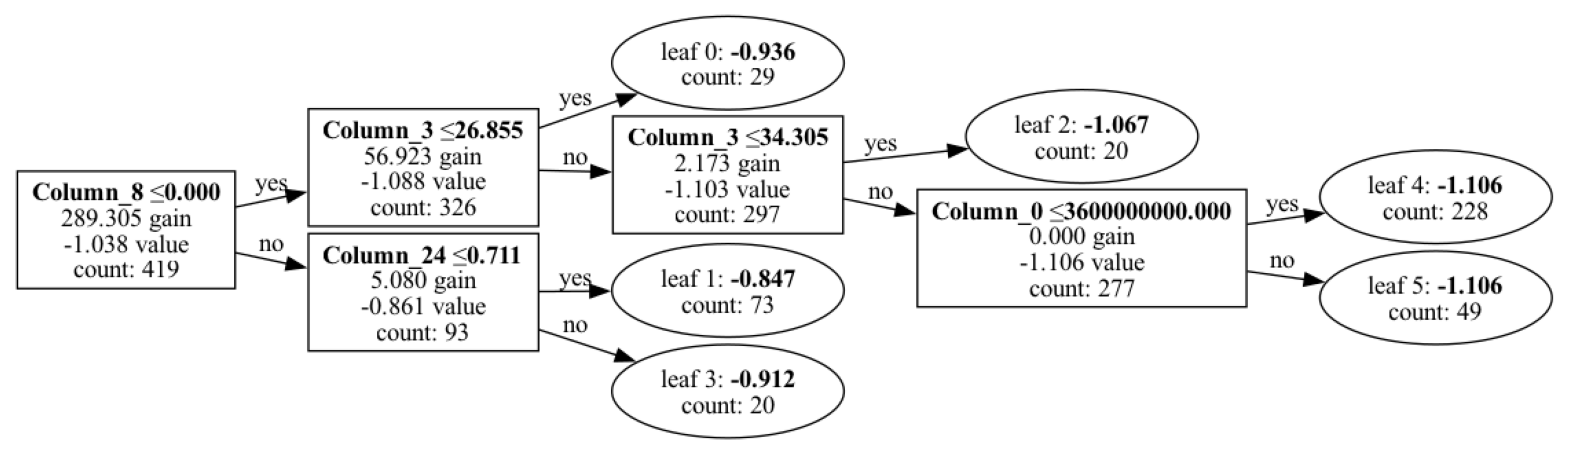

In [10]:
ax = lgb.plot_tree(clf_lgb, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
plt.show()
        

## 6. M2: Neural Networks

**Notes:**
- Needs input layer, hidden layer (more complex patterns, each of them makes the data even more abstract), output layer
- During training, netwoks adjusts itself to improve its acuracy
- Activation functions ??
- Types: Feedforward, convlutional, radial basis, recurrent
- Has optimization algos that adjust the weights (gradient descent for ex)
- Should we use it ? Data is non-linear, we need pattern recognition
- Use the perceptron we did in the labs ? 

In [11]:
import warnings
warnings.filterwarnings("ignore")

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler


In [12]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
print(torch.isnan(torch.from_numpy(X_train.astype(np.float32))).any())
print(torch.isinf(torch.from_numpy(X_train.astype(np.float32))).any())
print(torch.min(torch.from_numpy(X_train.astype(np.float32))))
print(torch.max(torch.from_numpy(X_train.astype(np.float32))))

tensor(False)
tensor(False)
tensor(-2.1463)
tensor(14.1872)


In [14]:
# must first convert data to torch tensors (?)
class Data(Dataset):
    def __init__(self, X_train, y_train):
        self.X = torch.from_numpy(X_train.astype(np.float32)) # added .values bcs it was a pd df, not a np array
        self.y = torch.from_numpy(y_train.to_numpy().astype(np.float32))
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.len

batch_size = 30

train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, drop_last=True)

for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break


Batch: 1
X shape: torch.Size([30, 29])
y shape: torch.Size([30])


In [15]:
input_dim = input_dim = X_train.shape[1]  # number of input variables
hidden_dim = 10 # hidden dimensions, arbitrary number of nodes
output_dim = 1 #nmbr of output nodes, just one

class NeuralNetwork(nn.Module): # inherits from nn module, base for all NNs
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")
        self.layer_2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.nn.functional.relu(self.layer_1(x))
        #x = torch.nn.functional.sigmoid(self.layer_2(x))
        x = self.layer_2(x)
        return x
    
model = NeuralNetwork(input_dim, hidden_dim, output_dim)
print(model)
        

NeuralNetwork(
  (layer_1): Linear(in_features=29, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)


In [16]:
learning_rate = 0.001

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


## The last code block is not stopping returns the results of just one batch

In [17]:
print(y_pred.shape, y.unsqueeze(-1).shape)


(131,) torch.Size([30, 1])


In [18]:
for X, y in train_dataloader:
    print(X.shape, y.shape)
    break


torch.Size([30, 29]) torch.Size([30])


In [19]:
print(torch.isnan(X).any())
print(torch.isinf(X).any())


tensor(False)
tensor(False)


In [20]:
print(y.unique()) # should only contain 0 and 1


tensor([0., 1.])


In [21]:
for X, y in train_dataloader:
    pred = model(X)
    print("Forward pass finished, pred shape:", pred.shape)
    break


Forward pass finished, pred shape: torch.Size([30, 1])


In [22]:
print("Train dataset size:", len(train_data))
print("Batch size:", batch_size)
num_batches = int(np.ceil(len(train_data) / batch_size))
print("Expected number of batches per epoch:", num_batches)


Train dataset size: 520
Batch size: 30
Expected number of batches per epoch: 18


In [23]:
for batch_idx, (X, y) in enumerate(train_dataloader):
    print(f"Batch {batch_idx+1}:")
    # outputs batch info for every batch in the dataset


Batch 1:
Batch 2:
Batch 3:
Batch 4:
Batch 5:
Batch 6:
Batch 7:
Batch 8:
Batch 9:
Batch 10:
Batch 11:
Batch 12:
Batch 13:
Batch 14:
Batch 15:
Batch 16:
Batch 17:
Batch 18:


In [24]:
print("pred dtype, shape:", pred.dtype, pred.shape)
print("y dtype, shape:", y.dtype, y.shape)
print("Unique y values:", y.unique())
print("Any NaN in pred?", torch.isnan(pred).any())
print("Any NaN in y?", torch.isnan(y).any())


pred dtype, shape: torch.float32 torch.Size([30, 1])
y dtype, shape: torch.float32 torch.Size([10])
Unique y values: tensor([0., 1.])
Any NaN in pred? tensor(False)
Any NaN in y? tensor(False)


In [25]:
def __getitem__(self, index):
    xitem, yitem = self.X[index], self.y[index]
    print("getitem:", xitem.shape, yitem.shape)
    return xitem, yitem


In [26]:
for batch_idx, (X, y) in enumerate(train_dataloader):
    print("X shape:", X.shape, "y shape:", y.shape)


X shape: torch.Size([30, 29]) y shape: torch.Size([30])
X shape: torch.Size([30, 29]) y shape: torch.Size([30])
X shape: torch.Size([30, 29]) y shape: torch.Size([30])
X shape: torch.Size([30, 29]) y shape: torch.Size([30])
X shape: torch.Size([30, 29]) y shape: torch.Size([30])
X shape: torch.Size([30, 29]) y shape: torch.Size([30])
X shape: torch.Size([30, 29]) y shape: torch.Size([30])
X shape: torch.Size([30, 29]) y shape: torch.Size([30])
X shape: torch.Size([30, 29]) y shape: torch.Size([30])
X shape: torch.Size([30, 29]) y shape: torch.Size([30])
X shape: torch.Size([30, 29]) y shape: torch.Size([30])
X shape: torch.Size([30, 29]) y shape: torch.Size([30])
X shape: torch.Size([30, 29]) y shape: torch.Size([30])
X shape: torch.Size([30, 29]) y shape: torch.Size([30])
X shape: torch.Size([30, 29]) y shape: torch.Size([30])
X shape: torch.Size([30, 29]) y shape: torch.Size([30])
X shape: torch.Size([30, 29]) y shape: torch.Size([30])
X shape: torch.Size([10, 29]) y shape: torch.Siz

In [27]:
print(len(train_data))  # should be 520
print(train_data.X.shape, train_data.y.shape)  # row counts should match


520
torch.Size([520, 29]) torch.Size([520])


In [28]:
print(type(X))
print(type(y))
print(type(pred))
print(y.is_contiguous())  # boolean -- should be True


<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
True


In [29]:
print(y)
print(y.shape, y.dtype)
print(y.storage_offset(), y.stride())


tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.])
torch.Size([10]) torch.float32
0 (1,)


In [ ]:
num_epochs = 10
loss_values = []

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}/{num_epochs}")
    for batch_idx, (X, y) in enumerate(train_dataloader):
        print("  Got batch from DataLoader")  # 1
        optimizer.zero_grad()
        pred = model(X)
        print("  Forward done")              # 2$
        print("pred device:", pred.device, "y device:", y.device)
        loss = loss_fn(pred, y.unsqueeze(-1))
        print("  Loss computed")             # 3
        loss.backward()
        print("  Backward done")             # 4
        optimizer.step()
        print("  Optimizer step done")       # 5
    print("Epoch finished")                  # 6
print("Training Complete")


Starting epoch 1/10
  Got batch from DataLoader
  Forward done
pred device: cpu y device: cpu
